# Full Animation: PID Throttle Control and Stanley Steering

In this exercise, you will be developing a complete animation of an autonomous car that utilizes **PID control** for throttle and **Stanley control** for steering. You'll implement the missing pieces of the code and adjust parameters to improve performance.

Basically we are gonna combine everything learnt till now to create a full working animation of how the car will run on the track.

We started by getting cone positions, we then got waypoints and interpolated them. We then optimised them. 

Now that we have the optimised path, we will use our knowledge of PID control and Stanley steering to race the car on the track!

A very simple point mass model has been implemented as the car for initial testing.

## Objectives:
1. Implement **PID throttle control** to maintain a desired speed.
2. Implement **Stanley steering** to follow a predefined path.
3. Tune the Stanley controller to achieve better path tracking.
4. Visualize the system's behavior using an animation.



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

Initially to get started load the map(waypoints) and plot to see the path you are trying to traverse


Add the Cones for Visualisation to make the animation look prettier


You can find all these files in the 'Checkpoint 4' folder

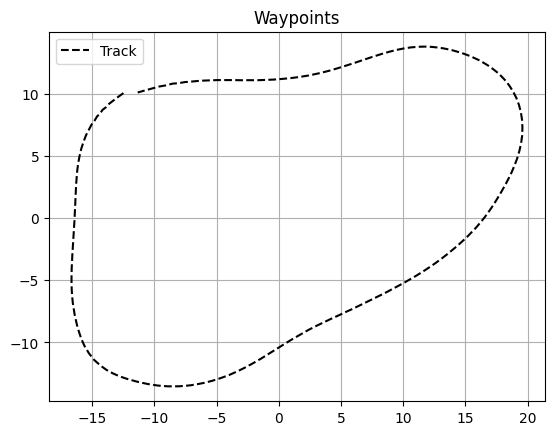

In [20]:

waypoints = np.load('waypoints.npy')
# This is the map which was obtained from optimising the waypoints

plt.plot(waypoints[:,0], waypoints[:,1], 'k--', label="Track")
plt.axis("equal")
plt.title("Waypoints")
plt.legend()
plt.grid()
plt.show()

#### Implement the car model
Currently the skeleton code has a kinematic bicylce model already implemented for you :)

##### Bonus:

After you implement the whole animation using this model you can try to implement the dynamic bicycle model you learned in AISD module

In [21]:
class Vehicle:
    def __init__(self, x=0, y=0, yaw=0 , v=0.0, L=2.5):  # Initial position, yaw, velocity, and wheelbase

        self.x = x              #  IMP ! : Change the initial pose of the car to determine the starting position
        self.y = y  
        self.yaw = yaw
        self.v = v
        self.L = L  # Wheelbase

    def update(self, throttle, delta, dt=0.1):
        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / self.L * np.tan(delta) * dt
        self.v += throttle * dt
        self.v = max(0.0, self.v)  # No reverse



def stanley_steering(x, y, yaw, v, waypoints, k=1.0, ks=1e-2, max_steer=np.radians(30)):
    """
    Stanley steering controller.

    Args:
        x, y     : rear axle position of the car
        yaw      : vehicle heading angle (in radians)
        v        : vehicle speed
        waypoints: Nx2 array of path waypoints
        k        : cross-track gain
        ks       : softening term to prevent div by zero
        max_steer: steering angle limits (in radians)

    Returns:
        steer       : steering angle in radians
        target_idx  : index of the nearest waypoint
    """
    # Step 1: Compute front axle position
    L = 2.5  # assume fixed wheelbase
    fx = x + L * np.cos(yaw)
    fy = y + L * np.sin(yaw)

    # Step 2: Find nearest waypoint
    x_dist = waypoints[:, 0] - fx
    y_dist = waypoints[:, 1] - fy
    dist = np.sqrt(x_dist**2 , y_dist**2)
    target_idx = np.argmin(dist)


    # Step 3: Compute heading of path at that point
    next_waypoint = waypoints[target_idx+1]
    path_dx = next_waypoint[0] - waypoints[target_idx][0] #getting slope of the path using  2points
    path_dy = next_waypoint[1] - waypoints[target_idx][1]
    path_yaw = np.arctan2(path_dy, path_dx)


    # Step 4: Compute heading error
    heading_error = path_yaw - yaw



    # Step 5: Compute signed cross-track error
    m = np.tan(path_yaw)
    c = waypoints[target_idx][1] - m * waypoints[target_idx][0]
    cross_track_error = abs(m * fx - fy + c) / np.sqrt(m**2 + 1) # perpendiuclar distance from a line formula 


    # Step 6: Compute steering using Stanley law
    steer = heading_error + np.arctan2(k * cross_track_error, v + ks) # write your code here
    steer = np.clip(steer, -max_steer, max_steer)

    return steer, target_idx



class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        # you might need to add more variables here... hint: for Integral controller
        self.sum_integral =0 #to sum(integrate) the error*dt term over and over again
        self.last_error  = 0# to get the d(e(t)) that is the change in errror

    def update(self, error, dt):
        '''
        write the update function on your own
        input is error and dt
        output should be the thrust that is provided to drone
        '''
        self.sum_integral += error*dt
        output = self.Kp*error + self.Ki *self.sum_integral + self.Kd * ((error - self.last_error)/dt)
        self.last_error = error
        return output
        
'''
Start with a P controller, then PD, then PI, and then PID, by trial and error
Your aim here is to tune the controller such that there is minimal overshoot and oscillations
'''
Kp = 1.0    #proportional constant
Ki = 0.0    #integral constant
Kd = 0.0    #derivative constant  # increase this if you want the animation to be longer
pid = PIDController(Kp, Ki, Kd)


def pid_throttle(target_speed, current_speed, dt):
    error = target_speed - current_speed
    return pid.update(error, dt)


### Implement Throttle and Steering control
 - Implement a PID controller for throttle to follow the velocity profile you created earlier
 - Implement the stanley controller function you created in the previous notebook for steering control
 - You will have to add these control functions in the utilities and then import them here to use them 

In [22]:
def compute_control(vehicle, waypoints, last_target_idx, k=5.0, k_soft=1e-2):
    """

    Args:
        vehicle: Vehicle object
        waypoints: Nx2 array
        last_target_idx: previously selected waypoint index
        k: control gain for Stanley
        k_soft: softening term to avoid division by zero

    Returns:
        throttle: float
        steer: float
        target_idx: int
    """
    
    x = vehicle.x
    y = vehicle.y
    yaw = vehicle.yaw
    v = vehicle.v
    # Limit steering to realistic bounds
    max_steer = np.radians(30)
    steer, target_idx = stanley_steering(x, y, yaw, v, waypoints)
    # Throttle control (simple proportional control or replace with PID)
    target_v = 10.0  # Target velocity You can change this velocity as per need

    # You must keep in mind that different target velocities will require retuning the steering gains

    throttle = pid_throttle(target_v, v, 0.05)# Make a pid function in utility.py and use it here

    return throttle, steer, target_idx


In [23]:

vehicle = Vehicle()
history = {'x': [], 'y': []}
target_idx = 0

fig, ax = plt.subplots(figsize=(6,6))
# ax.set_xlim(-12, 12)
# ax.set_ylim(-12, 12)
track_line, = ax.plot(waypoints[:,0], waypoints[:,1], 'k--')
car_dot, = ax.plot([], [], 'bo', markersize=6)
path_line, = ax.plot([], [], 'b-', linewidth=1)

def init():
    car_dot.set_data([], [])
    path_line.set_data([], [])
    return car_dot, path_line

def animate(i):
    global target_idx
    throttle, steer, target_idx = compute_control(vehicle, waypoints, target_idx)
    vehicle.update(throttle, steer)

    history['x'].append(vehicle.x)
    history['y'].append(vehicle.y)

    car_dot.set_data(vehicle.x, vehicle.y)
    path_line.set_data(history['x'], history['y'])
    return car_dot, path_line

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=300, interval=50, blit=True)
plt.close()  # Prevent double display in some notebooks

from IPython.display import HTML
HTML(ani.to_jshtml())


RuntimeError: x must be a sequence